# Intensity over z

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd
import glob
import os

def loadCSVFeatures(file):
    with open(file) as f:
        row_count = 0
        row = f.readline()
        while row.startswith('#'):
            row = f.readline()
            row_count += 1
    metadata = pd.read_csv(file, skiprows=row_count, nrows=1, index_col=0).to_dict('records')[0]
    features = pd.read_csv(file, skiprows=row_count + 2, index_col=0)
    return features, metadata


In [2]:
px, py = np.loadtxt('area_to_um.txt')
px.shape

(28,)

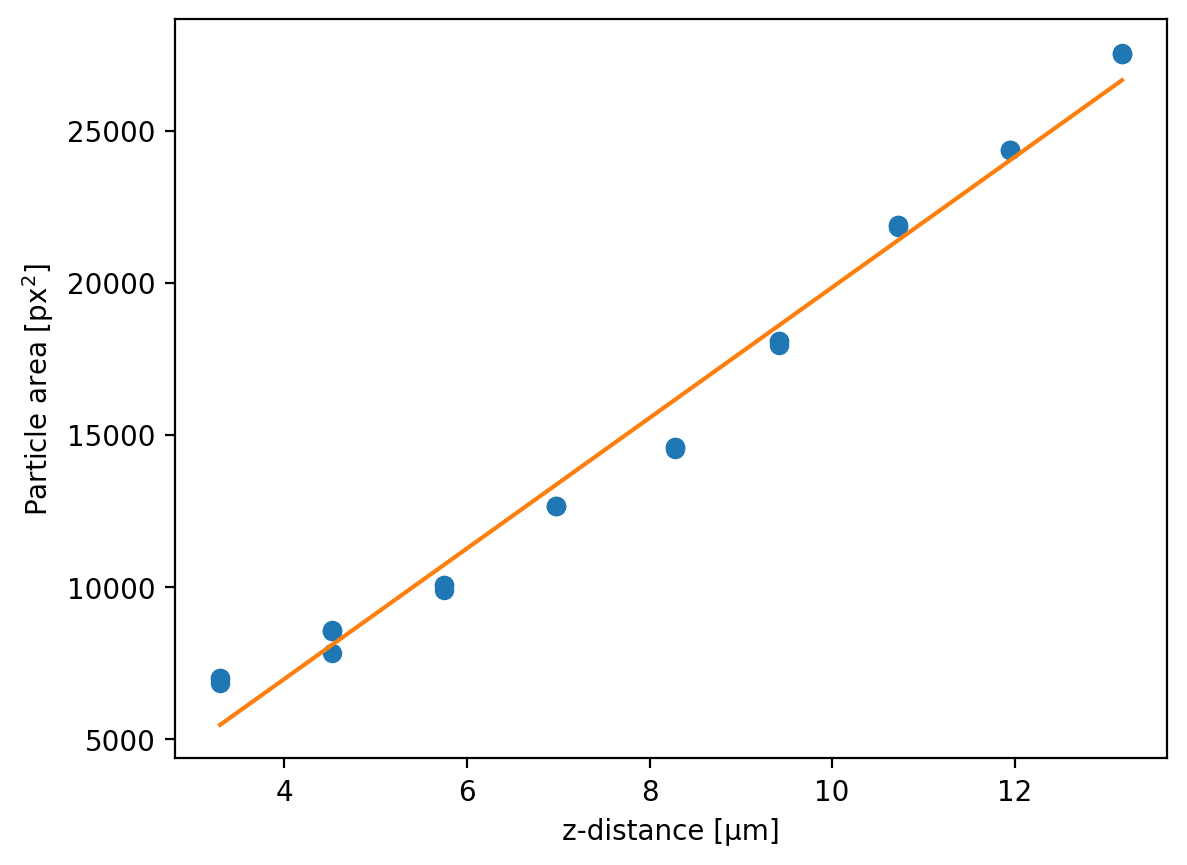

In [3]:
plt.plot(px, py, 'o')
fit_areaa, fit_areab = np.polyfit(px,py, 1)
plt.plot(px,px*fit_areaa + fit_areab)
plt.xlabel('z-distance [µm]')
plt.ylabel('Particle area [px$^2$]');

In [4]:
import nptdms
from os import listdir
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps

In [5]:
images = []
voltages = []
for i,fname in enumerate(listdir("Particle over z calibration")):
    if "index" in fname:
        continue
    file = nptdms.TdmsFile.read("Particle over z calibration/"+fname)
    voltage = int(fname[5:8])
    voltages.append(voltage)
    props = file.properties
    shape = [int(d) for d in (props["frames"],props["dimx"],props["dimy"])]
    img=np.array(file["Image"]["Image"][:]).reshape(*shape)

    images.append(img[0])
    # images.append(img[1])



In [46]:
def freq(idx,size):
    if(idx==0):
        return 0
    if(idx <= size//2):
        return idx
    if(idx > size//2+1):
        return idx-size
    else:
        return 0
def low_pass_filter(adata: np.ndarray, bandlimit: int = 1) -> np.ndarray:
    # translate bandlimit from Hz to dataindex according to sampling rate and data size
    bandlimit_index = int(bandlimit * adata.shape[1])
    print(bandlimit_index)

    fsig = np.fft.fft2(adata)
    
    for i in range(adata.shape[0]):
        for j in range(adata.shape[1]):
            if(np.sqrt(freq(i,adata.shape[0])**2+freq(j,adata.shape[1])**2)> bandlimit_index):
                fsig[i,j] = 0
    adata_filtered = np.fft.ifft2(fsig)

    return np.real(adata_filtered)

102


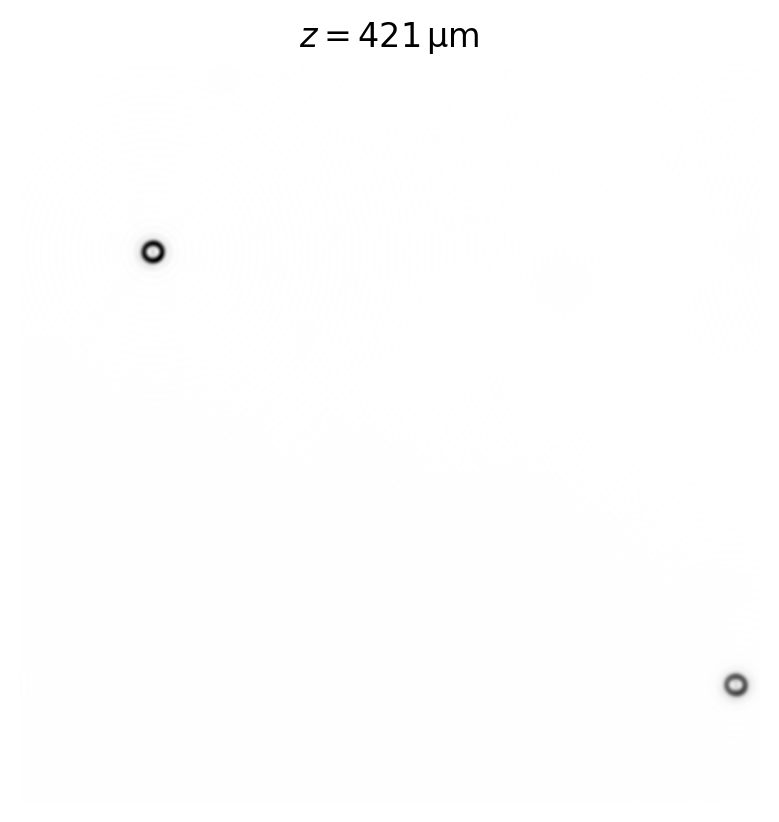

102


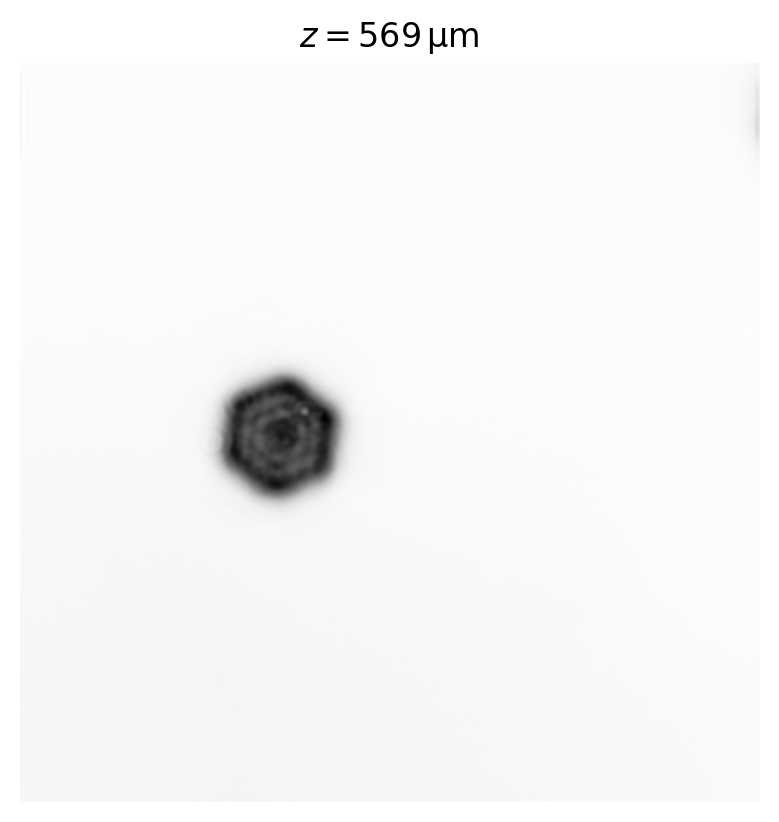

In [58]:
# voltages = [536,552,568,585,600,617,633,649,665,681,697,713,729,745,761]
for i,(img,U) in enumerate(zip(images,voltages)):
    if(i==2):
        break
    filtered_img = low_pass_filter(img,0.05)
    plt.imshow(filtered_img,cmap=cmaps["Grays"])
    plt.title(f"$z = {0.7654075546719683*U + 10.953379721669984:.3g}\\,\\mathrm{{\\mu m}}$")
    plt.axis("off")
    plt.show()

    


In [50]:
image[...,0].

44740